In [1]:
from ISLP import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = load_data('Weekly')

In [3]:
data.dtypes

Year           int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Volume       float64
Today        float64
Direction     object
dtype: object

In [4]:
data.isnull().sum() / len(data) * 100

Year         0.0
Lag1         0.0
Lag2         0.0
Lag3         0.0
Lag4         0.0
Lag5         0.0
Volume       0.0
Today        0.0
Direction    0.0
dtype: float64

We'll need to convert the direction variables into actual numbers. We can either go with One Hot Encoding, or label encoding.

I'm selecting the label encoding approach for now, to avoid problems with dummy variables. Limitations aside, its just faster this way.

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Direction'] = encoder.fit_transform(data['Direction'])

In [6]:
import statsmodels.api as sm
response = data[['Direction']]
predictors = data[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]

### 1.a)

In [7]:
regressor = sm.Logit(response, predictors).fit()
regressor.summary()

Optimization terminated successfully.
         Current function value: 0.686896
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1083
Method:                           MLE   Df Model:                            5
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:               9.505e-05
Time:                        16:37:52   Log-Likelihood:                -748.03
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.9996
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag1          -0.0327      0.026     -1.250      0.211      -0.084       0.019
Lag2           0.0682      0.027      2.556      0.011       0.016       0.120
Lag3          -0.0081      0.026     -0.306      0.759      -0.060       0.044
Lag4          -0.0194      0.026     -0.740      0.459      -0.071       0.032
Lag5          -0.0069      0.026     -0.261      0.794      -0.058       0.045
Volume         0.0569      0.027      2.125      0.034       0.004       0.109
==============================================================================
"""

### b) Assuming a p value of 0.05; the variables: Lag 2 and Volume can reject the null hypothesis BetaJ = 0.

### c)

In [8]:
# Make predictions on seen data
predictions = regressor.predict(predictors)
predictions = list(map(round, predictions))

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(response, predictions)
print('The accuracy of this model is approximately', accuracy_score(response, predictions).round(2))

The accuracy of this model is approximately 0.55


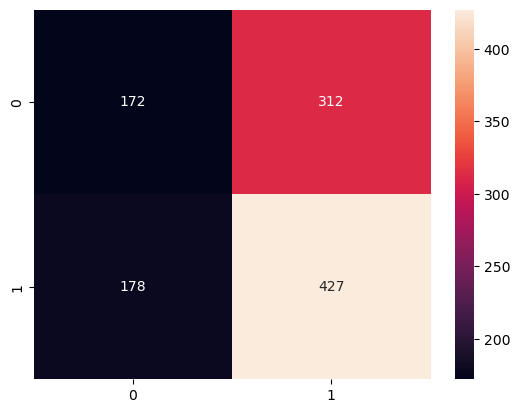

In [10]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt='d')

The fraction for correct predictions can me expressed this way:

(172 + 427) / 1089

### d)

Note: Since we converted the response variable to 0 and 1; here's the key:

0: Down
1: Up

The encoder passes through values and transforms them in alphabetical order.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA_classifier = LinearDiscriminantAnalysis(store_covariance=True)
LDA_classifier.fit(predictors, response.values.ravel())

LinearDiscriminantAnalysis(store_covariance=True)

In [12]:
# predict for seen data like above
LDA_predictions = LDA_classifier.predict(predictors)

In [13]:
# confusion matrix and score
print('Accuracy score for this model is', accuracy_score(response, LDA_predictions).round(2))
LDA_cm = confusion_matrix(response, LDA_predictions)

Accuracy score for this model is 0.56


<Axes: >

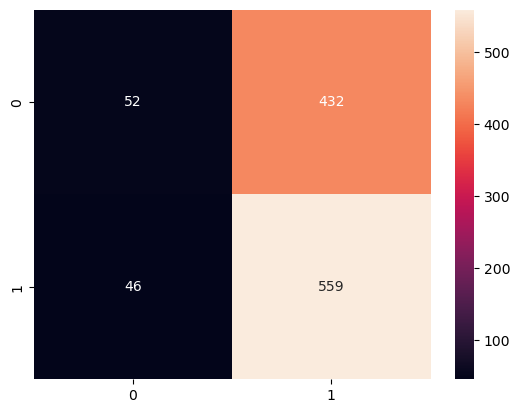

In [14]:
sns.heatmap(LDA_cm, annot=True, fmt='d')

LDA performs only slightly better when fitting the whole dataset to the model. (55% vs. 56% accuracy of predictions)

### 2c)

In [15]:
logit_data = pd.read_csv('C:/Users/ldmag/Downloads/logit_data.csv')

In [16]:
logit_data.describe()

,grade,hours
count,500.000000,500.00000
mean,0.746000,8.22240
std,0.435734,4.95342
min,0.000000,0.00000
25%,0.000000,4.10000
50%,1.000000,8.20000
75%,1.000000,12.50000
max,1.000000,16.90000


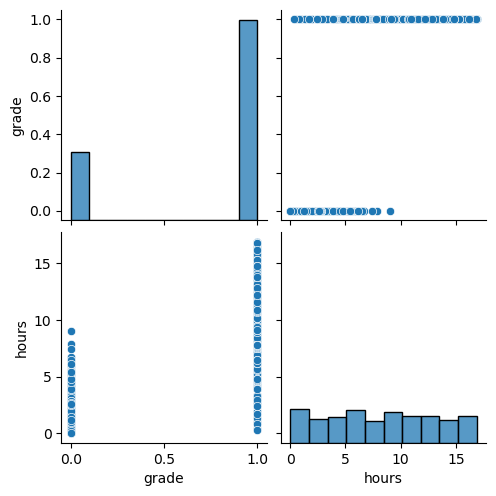

In [17]:
sns.pairplot(logit_data)

In [18]:
# fit a generalized linear model, after finding distribution
glm = sm.GLM(logit_data.grade, logit_data.hours, family=sm.families.Binomial())

In [19]:
glm_results = glm.fit()

In [20]:
glm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  grade   No. Observations:                  500
Model:                            GLM   Df Residuals:                      499
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -178.87
Date:                Mon, 06 Nov 2023   Deviance:                       357.75
Time:                        16:37:56   Pearson chi2:                     330.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3416
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hours          0.2677      0.022     11.906      0.000       0.224       0.312
==============================================================================
"""

In [21]:
glm_results.params

hours    0.267736
dtype: float64

MLE for Beta using a GLM is 0.267

### d)

Note: Can't use the slides as reference for this. :(

In [22]:
x = logit_data.hours
y = logit_data.grade
alpha = 0.001
epsilon = 1e-8
beta = np.array([0,0])
gradient_t = np.array([0,0])
betas = [beta.copy()]
error = epsilon+1

# fixed - bracket issue on exponent terms (some weird crap)
while error > epsilon:
    exponent_exp = np.exp(beta[0]+beta[1]*x)
    gradient_t = np.array([np.sum(y) - np.sum(exponent_exp/(1+exponent_exp)), np.sum(y*x) - np.sum(x*exponent_exp/(1+exponent_exp))])
    update_beta = beta + alpha * gradient_t
    betas.append(update_beta)
    error = np.linalg.norm(update_beta-beta)
    beta = update_beta

In [23]:
# recast because the previous version is a list of arrays
betas = np.array(betas)

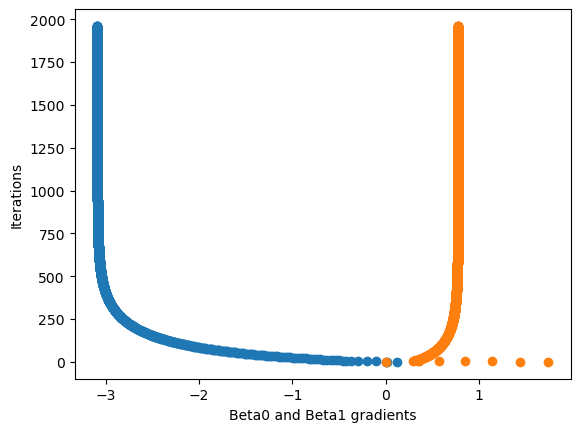

In [24]:
plt.scatter(betas[:,0], range(len(betas)))
plt.scatter(betas[:,1], range(len(betas)))
plt.xlabel("Beta0 and Beta1 gradients")
plt.ylabel("Iterations")
plt.show()

### e)

In [30]:
# coefficients for both gradients are
print('Beta0:', betas[-1][0])
print('Beta1:', betas[-1][1])

Beta0: -3.0905330676609255
Beta1: 0.7750839642283504


In [36]:
z = np.exp(betas[-1][0]+betas[-1][1]*10)
prob_y1 = 1/(1+np.exp(-z))
prob_y0 = 1-prob_y1
print(prob_y0)

0.0


If we do this by hand, the answer is P(y=0) = 0.0094

Additional Visualizations

<Axes: >

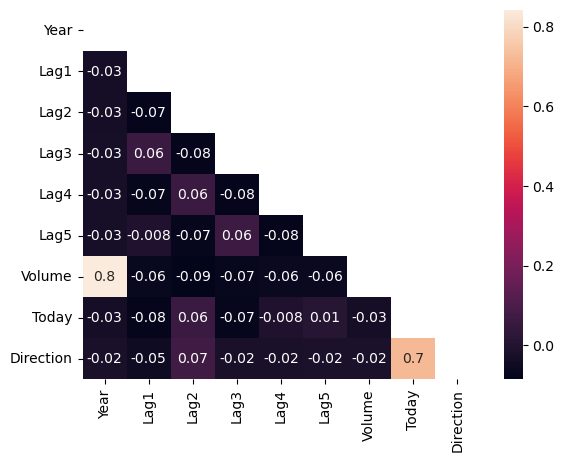

In [25]:
#import seaborn as sns
c = data.corr()

mask = np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c, mask=mask, annot=True, fmt='.1g')

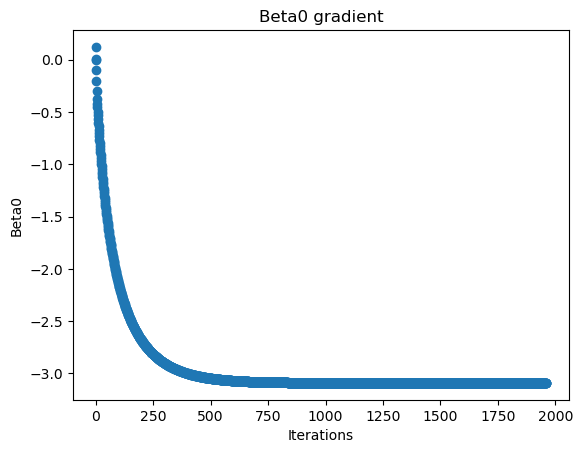

In [26]:
plt.scatter(x=range(len(betas)), y=betas[:,0])
plt.xlabel("Iterations")
plt.ylabel("Beta0")
plt.title('Beta0 gradient')
plt.show()

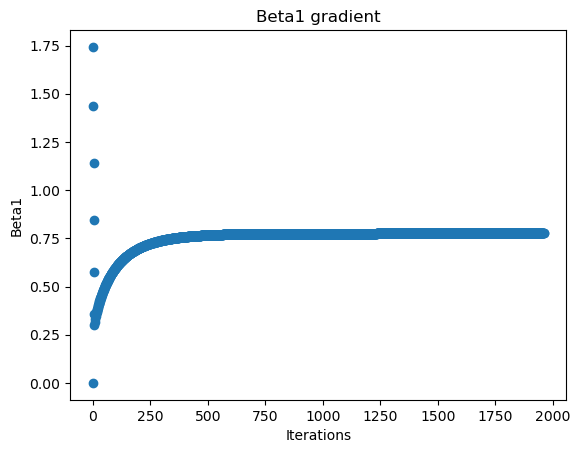

In [27]:
plt.scatter(x=range(len(betas)), y=betas[:,1])
plt.xlabel("Iterations")
plt.ylabel("Beta1")
plt.title('Beta1 gradient')
plt.show()